# CSC 792 Assignment 6 - Stock Market Prediction

## Mangesh Sakordekar (7440013)

### Imports

In [171]:
import os
import numpy as np
from matplotlib.pyplot import *
from scipy.misc import *
from skimage import color
from skimage import io
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt

### Reading data 
American Airlines stock data was used for this project

In [172]:
data = open("aal.csv", "r")
data = data.read()
data = data.split('\n')

In [173]:
headers = data[0].split(',')
lines = data[1:-1]

In [174]:
highs = np.zeros((len(lines),))
lows = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(headers) - 2))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:6]]
    highs[i] = values[1]
    lows[i] = values[2]
    raw_data[i, :] = values[:]

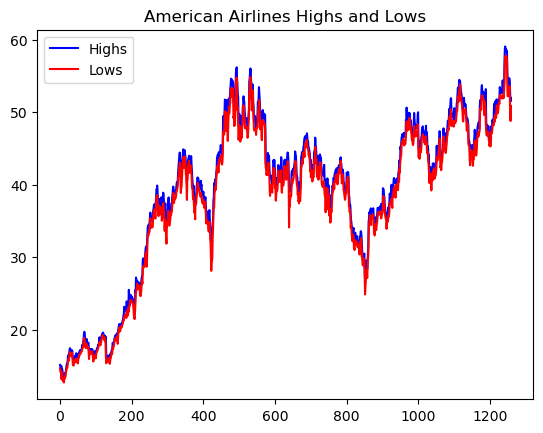

In [175]:
plt.figure()
plt.plot(range(len(highs)), highs, "b", label="Highs")
plt.plot(range(len(lows)), lows, "r", label="Lows")
plt.title("American Airlines Highs and Lows")
plt.legend()
plt.show()

### Splitting into train, validation and test datasets

In [176]:
num_train_samples = int(0.5 * len(highs))
num_val_samples = int(0.25 * len(highs))
num_test_samples = len(highs) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 629
num_val_samples: 314
num_test_samples: 316


#### Normalizing raw data

In [177]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

### Training model for highs

#### Creating time series dataset

In [178]:
sampling_rate = 1
sequence_length = 21
delay = sampling_rate * (sequence_length)
batch_size = 4

In [179]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=highs[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=highs[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=highs[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

#### Evaluating Naive Method

In [180]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    #print(samples_seen)
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 0.56
Test MAE: 0.62


#### Train the model using highs of the day

In [181]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(128, recurrent_dropout=0.25)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("highs_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model_highs = keras.models.load_model("highs_lstm.keras")
print(f"Test MAE: {model_highs.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
153/153 [==============================] - 8s 26ms/step - loss: 393.2347 - mae: 16.0296 - val_loss: 95.1305 - val_mae: 8.8183
Epoch 2/50
153/153 [==============================] - 3s 22ms/step - loss: 53.7238 - mae: 5.1556 - val_loss: 14.4535 - val_mae: 3.0953
Epoch 3/50
153/153 [==============================] - 3s 19ms/step - loss: 9.8420 - mae: 2.3767 - val_loss: 3.7184 - val_mae: 1.5160
Epoch 4/50
153/153 [==============================] - 3s 21ms/step - loss: 6.9343 - mae: 1.8327 - val_loss: 4.2756 - val_mae: 1.6886
Epoch 5/50
153/153 [==============================] - 3s 20ms/step - loss: 4.2910 - mae: 1.5888 - val_loss: 3.6486 - val_mae: 1.4993
Epoch 6/50
153/153 [==============================] - 3s 18ms/step - loss: 4.9978 - mae: 1.4931 - val_loss: 1.9792 - val_mae: 1.1504
Epoch 7/50
153/153 [==============================] - 3s 18ms/step - loss: 3.1150 - mae: 1.3576 - val_loss: 2.7942 - val_mae: 1.3560
Epoch 8/50
153/153 [==============================] - 3s 18ms/s

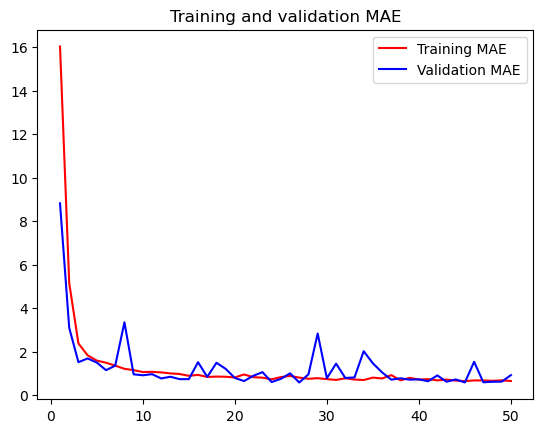

In [182]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Train Model for Lows

#### Create timeseries data

In [183]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=lows[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=lows[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=lows[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

#### Evaluating Naive model

In [184]:
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 1.16
Test MAE: 1.12


#### Tarin the model for lows

In [185]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(128, recurrent_dropout=0.25)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("lows_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model_lows = keras.models.load_model("lows_lstm.keras")
print(f"Test MAE: {model_lows.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
153/153 [==============================] - 12s 49ms/step - loss: 383.8086 - mae: 15.9365 - val_loss: 87.7815 - val_mae: 8.4423
Epoch 2/50
153/153 [==============================] - 7s 45ms/step - loss: 51.2689 - mae: 5.0458 - val_loss: 14.2768 - val_mae: 3.2222
Epoch 3/50
153/153 [==============================] - 7s 45ms/step - loss: 11.3354 - mae: 2.3818 - val_loss: 6.9484 - val_mae: 2.0665
Epoch 4/50
153/153 [==============================] - 7s 44ms/step - loss: 5.7532 - mae: 1.8550 - val_loss: 3.8881 - val_mae: 1.6976
Epoch 5/50
153/153 [==============================] - 7s 44ms/step - loss: 10.6601 - mae: 1.6790 - val_loss: 3.4860 - val_mae: 1.5506
Epoch 6/50
153/153 [==============================] - 7s 43ms/step - loss: 16.4909 - mae: 1.8081 - val_loss: 14.7232 - val_mae: 3.3195
Epoch 7/50
153/153 [==============================] - 7s 44ms/step - loss: 3.2264 - mae: 1.3529 - val_loss: 3.3575 - val_mae: 1.2022
Epoch 8/50
153/153 [==============================] - 7s 4

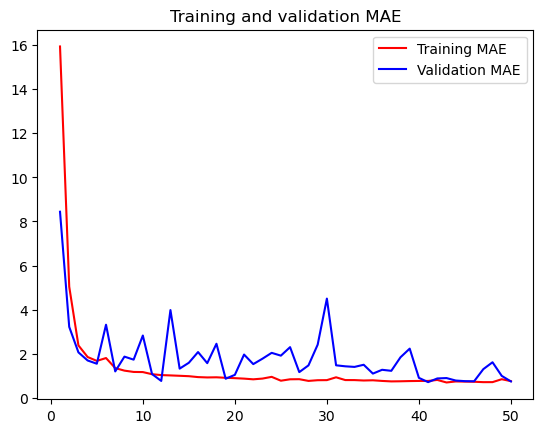

In [186]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Predicting using the Test Data

In [187]:
test_data = raw_data[-num_test_samples:, :]
test_highs = highs[-num_test_samples:]
test_lows = lows[-num_test_samples:]

In [188]:
preds_highs = test_highs[:delay]
preds_lows = test_lows[:delay]

In [189]:
i = 0
j = delay

while j < len(test_data):
    prev = np.reshape(test_data[i:j, :], (1, delay, raw_data.shape[1]))
    
    preds = model_highs.predict(prev, verbose=0)[0][0]
    preds_highs = np.append(preds_highs, preds)
    
    preds = model_lows.predict(prev, verbose=0)[0][0]
    preds_lows = np.append(preds_lows, preds)
    i += 1
    j += 1

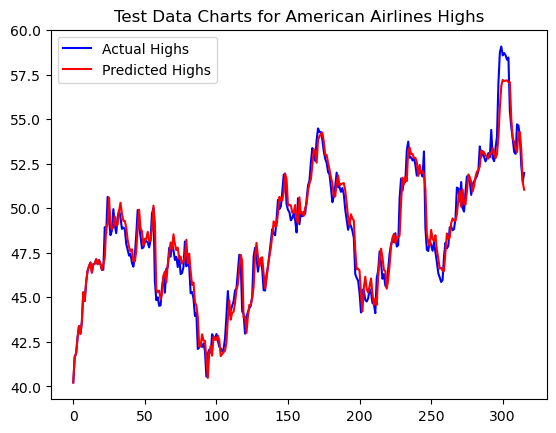

In [190]:
plt.figure()
plt.plot(range(len(test_highs)), test_highs, "b", label="Actual Highs")
plt.plot(range(len(preds_highs)), preds_highs, "r", label="Predicted Highs")
plt.title("Test Data Charts for American Airlines Highs")
plt.legend()
plt.show()

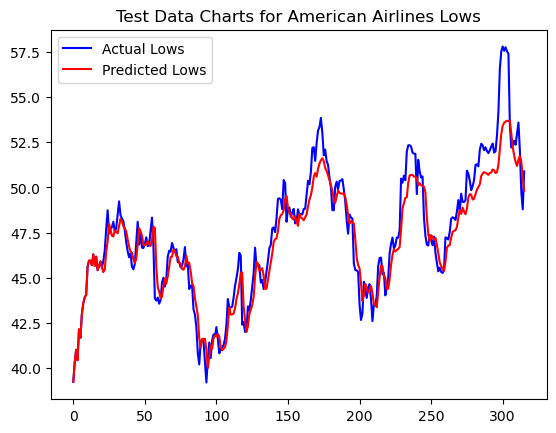

In [191]:
plt.figure()
plt.plot(range(len(test_lows)), test_lows, "b", label="Actual Lows")
plt.plot(range(len(preds_lows)), preds_lows, "r", label="Predicted Lows")
plt.title("Test Data Charts for American Airlines Lows")
plt.legend()
plt.show()

### Testing the model on Delta Airlines Stock

#### Read data for Delta Airline stock

In [192]:
delta = open("delta.csv", "r")
delta = delta.read()
delta = delta.split('\n')

In [193]:
delta_headers = delta[0].split(',')
delta_lines = delta[1:-1]

In [194]:
delta_highs = np.zeros((len(delta_lines),))
delta_lows = np.zeros((len(delta_lines),))
delta_data = np.zeros((len(delta_lines), len(delta_headers) - 2))
for i, line in enumerate(delta_lines):
    values = [float(x) for x in line.split(",")[1:6]]
    delta_highs[i] = values[1]
    delta_lows[i] = values[2]
    delta_data[i, :] = values[:]

#### Normalize the dsta

In [195]:
delta_data -= mean
delta_data /= std

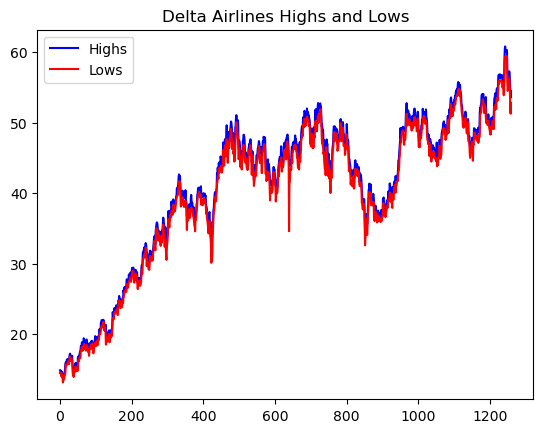

In [196]:
plt.figure()
plt.plot(range(len(delta_highs)), delta_highs, "b", label="Highs")
plt.plot(range(len(delta_lows)), delta_lows, "r", label="Lows")
plt.title("Delta Airlines Highs and Lows")
plt.legend()
plt.show()

### Predict highs and lows for Delta Airlines

In [225]:
delta_data = delta_data[num_train_samples:, :]
delta_highs = delta_highs[num_train_samples : ]
delta_lows = delta_lows[num_train_samples : ]

In [226]:
delta_preds_highs = delta_highs[:delay]
delta_preds_lows = delta_lows[:delay]

In [227]:
i = 0
j = delay

while j < len(delta_highs):
    prev = np.reshape(delta_data[i:j, :], (1, delay, delta_data.shape[1]))
    
    preds = model_highs.predict(prev, verbose=0)[0][0]
    delta_preds_highs = np.append(delta_preds_highs, preds)
    
    preds = model_lows.predict(prev, verbose=0)[0][0]
    delta_preds_lows = np.append(delta_preds_lows, preds)
    i += 1
    j += 1

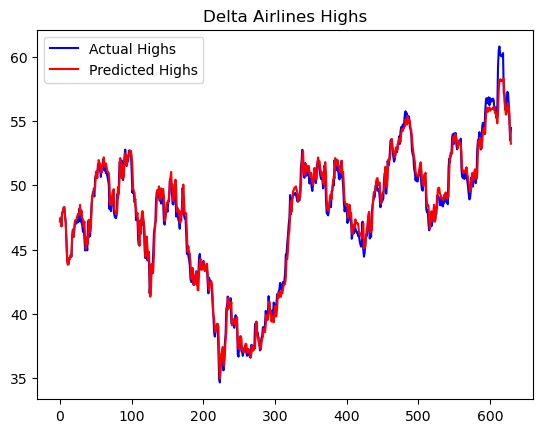

In [228]:
plt.figure()
plt.plot(range(len(delta_highs)), delta_highs, "b", label="Actual Highs")
plt.plot(range(len(delta_preds_highs)), delta_preds_highs, "r", label="Predicted Highs")
plt.title("Delta Airlines Highs")
plt.legend()
plt.show()

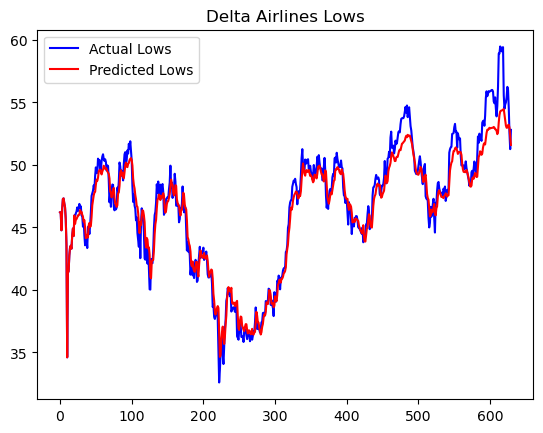

In [229]:
plt.figure()
plt.plot(range(len(delta_lows)), delta_lows, "b", label="Actual Lows")
plt.plot(range(len(delta_preds_lows)), delta_preds_lows, "r", label="Predicted Lows")
plt.title("Delta Airlines Lows")
plt.legend()
plt.show()

In [230]:
delta_dataset = keras.utils.timeseries_dataset_from_array(
    delta_data[:-delay],
    targets=delta_highs[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0)

In [231]:
print(f"Delta dataset MAE: {model_highs.evaluate(delta_dataset)[1]:.2f}")

148/148 [==============================] - 1s 7ms/step - loss: 0.5246 - mae: 0.5762
Delta dataset MAE: 0.58


In [232]:
delta_dataset = keras.utils.timeseries_dataset_from_array(
    delta_data[:-delay],
    targets=delta_lows[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0)

In [233]:
print(f"Delta dataset MAE: {model_lows.evaluate(delta_dataset)[1]:.2f}")

148/148 [==============================] - 1s 7ms/step - loss: 1.1992 - mae: 0.8369
Delta dataset MAE: 0.84


### Investment Stratergy

In [234]:
def invest(high, low, preds, amount):
    gain = 0
    bank = amount
    for i in range(21, len(high)-1):
        if preds[i+1] > high[i]:
            # Safe Statergy
            # Buy just value of one stock when a rise is predicted
            gain += high[i+1] - high[i]
            
            # Aggressive Statergy
            # Use the whole bank to buy stocks when a rise is predicted
            bank *= high[i+1]/high[i]
            
    return gain, bank

In [235]:
# Assumes the low of the day comes befor the high of the day
# buys on predicted low and sells on predicted high
def investPreds(high, low, p_high, p_low, amount):
    bank = amount
    maximum = amount
    for i in range(21, len(high)):
        
        # predicted case
        if p_high[i] > p_low[i]:
            bank *= min(p_high[i], high[i]) / max(p_low[i], low[i])
            
        # ideal case 
        if high[i] > low[i]:
            maximum *= high[i] / low[i]
    return bank, maximum

#### Using the model in an Investment Stratergy for the Americal Airlines Stock (316 days)

In [236]:
strat1, strat2 = invest(test_highs, test_lows, preds_highs, 10)
print("Amount earned using statergy 1 : ", strat1)
print("Amount earned using statergy 2 : ", strat2)

Amount earned using statergy 1 :  38.97429999999999
Amount earned using statergy 2 :  22.11801860260524


In [237]:
amnt, ideal = investPreds(test_highs, test_lows, preds_highs, preds_lows, 10)
print("Amount earned using predicted data : ", amnt)
print("Amount earned using ideal case : ", ideal)

Amount earned using predicted data :  486.8257972380498
Amount earned using ideal case :  12573.510077359597


#### Using the model in an Investment Stratergy for the Delta Airlines Stock (630 days)

In [238]:
strat1, strat2 = invest(delta_highs, delta_lows, delta_preds_highs, 10)
print("Amount earned using statergy 1 : ", strat1)
print("Amount earned using statergy 2 : ", strat2)

Amount earned using statergy 1 :  53.665600000000026
Amount earned using statergy 2 :  31.541336214679646


In [239]:
amnt, ideal = investPreds(delta_highs, delta_lows, delta_preds_highs, delta_preds_lows, 10)
print("Amount earned using predicted data : ", amnt)
print("Amount earned using ideal case : ", ideal)

Amount earned using predicted data :  16568.420486769573
Amount earned using ideal case :  17117576.07705455
